In [34]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LinearRegression as lr

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [4]:
df_sales = pd.read_csv('sales_history.csv', index_col=0)
df_sales = df_sales[df_sales['soldpieces'] > 0.01]
df_sales['price'] = df_sales['salerevenuerub']/df_sales['soldpieces']

In [19]:
# rondom group
# use clustering for it
df_sales['posid_gr'] = (df_sales['posid']*0.0001).astype(int)
df_sales['posid_gr'].value_counts()

27    6587268
28    3831813
29    2203607
26    1393120
31     681834
30     553743
32       8575
Name: posid_gr, dtype: int64

In [23]:
df_sales[df_sales['soldpieces'] > 10].sample(2)

,salerevenuerub,soldpieces,skutertiaryid,posid,sale_dt,price,posid_gr
19115409,1013.272304,15,7234,273905,2020-11-02,67.551487,27
2797353,1912.809023,29,7234,289458,2018-10-29,65.958932,28


In [ ]:
id_sku = df_sales['skutertiaryid'] == 7234
id_shop = df_sales['posid'] == 273905
df_sku_shop = df_sales[id_sku&id_shop]

df_sku_shop['log_price'] = np.log(df_sku_shop['price'])
df_sku_shop['log_Q'] = np.log(df_sku_shop['soldpieces'])

print(df_sku_shop.shape

In [47]:
lr_1 = lr(n_jobs=1)

lr_1.fit(
    df_sku_shop[['log_price']],
    df_sku_shop['log_Q']
)

q_pred = lr_1.predict( df_sku_shop[['log_price']])

In [64]:
# coefficients:
# log(Q) = b + k*log(P)
# get [b,k]
coefs = [lr_1.intercept_, lr_1.coef_[0]]
coefs

[10.052324898411722, -1.9245353037168886]

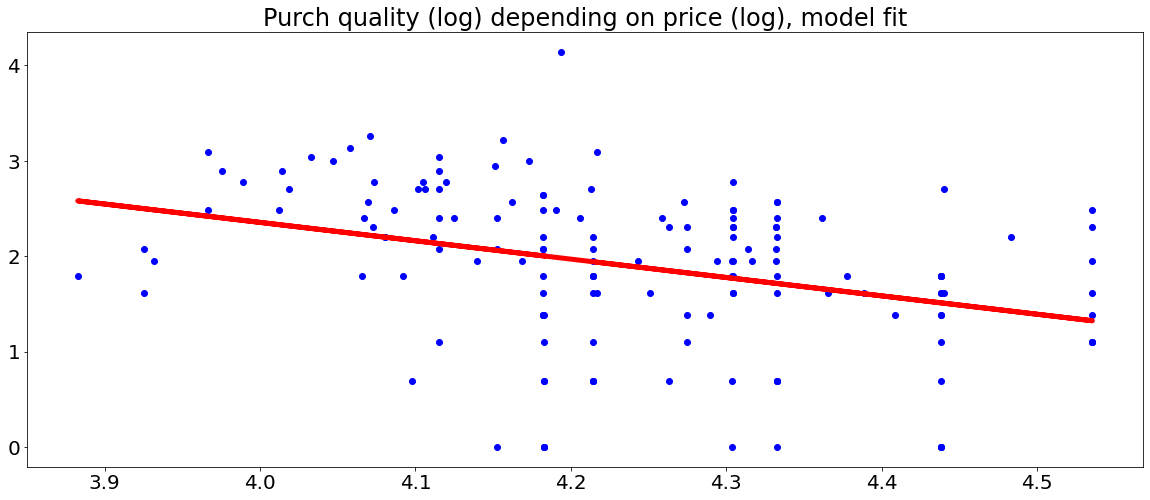

In [55]:
plt.figure(figsize=(20, 8))

plt.scatter(
    df_sku_shop['log_price'],
    df_sku_shop['log_Q'],
    color='blue'
);

plt.plot(
    df_sku_shop['log_price'],
    q_pred, 
    linewidth=5,
    color='red', 
)

plt.title('Purch quality (log) depending on price (log), model fit');
plt.rcParams.update({'font.size': 20});
plt.savefig('plots/Purch_log_quality_depending_on_log_price_model')

In [ ]:
# many linear models: 

In [67]:
df_sales = df_sales.assign(
    log_price = np.log(df_sales['price']),
    log_Q = np.log(df_sales['soldpieces'])
)

In [ ]:
cols = ['soldpieces', 'skutertiaryid', 'posid', 'log_price', 'log_Q']
res = []
iter_ = 0

for pos_sku, df in df_sales[cols]\
    .groupby(['posid', 'skutertiaryid']):
    
    if iter_ % 1000 == 0:
        print(f'Iter: {iter_}')
    
    lr_curr = lr(n_jobs=1)
    lr_curr.fit(
        df[['log_price']],
        df['log_Q']
    )
    
    b = lr_curr.intercept_
    k = lr_curr.coef_[0]
    #q_pred = lr_1.predict( df_sku_shop[['log_price']])
    
    res.append([pos_sku[0], pos_sku[1], b, k])
    iter_ = iter_ + 1

In [107]:
df_res = pd.DataFrame(
    res,
    columns=['pos', 'sku', 'b', 'k']
)

In [109]:
df_res.to_csv('models_res.csv', index=False)

In [113]:
# good
df_res[df_res['k'] < -0.01].shape

(133205, 4)

In [ ]:
# k distribution

----

#### Elastisity models for each sku

In [114]:
df_sales.head()

,salerevenuerub,soldpieces,skutertiaryid,posid,sale_dt,price,posid_gr,log_price,log_Q
0,174.41639,2,7182,293136,2018-04-30,87.208195,29,4.468298,0.693147
1,261.64140,3,7182,293136,2018-04-23,87.213800,29,4.468363,1.098612
2,78.75025,1,7182,296672,2018-04-30,78.750250,29,4.366281,0.000000
3,630.03563,8,7182,296672,2018-04-23,78.754454,29,4.366335,2.079442
4,239.12051,3,7182,296833,2018-04-30,79.706837,29,4.378355,1.098612


In [119]:
df_agg = df_sales.groupby(['skutertiaryid', 'sale_dt']).agg({
    'salerevenuerub': 'sum', 
    'soldpieces': 'sum'
}).reset_index()

df_agg = df_agg.assign(
    price = df_agg['salerevenuerub']/df_agg['soldpieces'],
    price_log = np.log(df_agg['salerevenuerub']/df_agg['soldpieces']),
    Q_log = np.log(df_agg['salerevenuerub'])
)

In [120]:
df_agg.head()

,skutertiaryid,sale_dt,salerevenuerub,soldpieces,price,price_log,Q_log
0,7182,2018-04-23,4.067299e+06,48862,83.240529,4.421734,15.218490
1,7182,2018-04-30,7.811600e+05,9381,83.270440,4.422094,13.568535
2,7182,2018-05-01,3.837060e+06,46044,83.334642,4.422864,15.160217
3,7182,2018-05-07,4.894995e+06,63986,76.501031,4.337304,15.403724
4,7182,2018-05-14,4.523049e+06,57705,78.382267,4.361598,15.324697


In [127]:
cols = ['soldpieces', 'skutertiaryid', 'price_log', 'Q_log']
res = []
iter_ = 0

for sku, df in df_agg[cols]\
    .groupby(['skutertiaryid']):
        
    lr_curr = lr(n_jobs=1)
    lr_curr.fit(
        df[['price_log']],
        df['Q_log']
    )
    
    b = lr_curr.intercept_
    k = lr_curr.coef_[0]
    
    res.append([sku, b, k])

In [137]:
df_res = pd.DataFrame(
    res,
    columns=['sku', 'b', 'k']
)

df_res

,sku,b,k
0,7182,28.139683,-2.967457
1,7189,21.989374,-2.922235
2,7193,23.623860,-2.627659
3,7194,28.713401,-3.130444
4,7205,19.421810,-1.670798
5,7232,21.101555,-1.395074
6,7234,22.510221,-1.474848
7,7236,12.068925,0.295350
8,7238,2.414435,3.323683
9,7247,11.125502,0.598496


In [164]:
b = 28.139683
k = -2.967457

#q_pred = np.exp(k*np.log(df_agg[ids]['price']) + b)

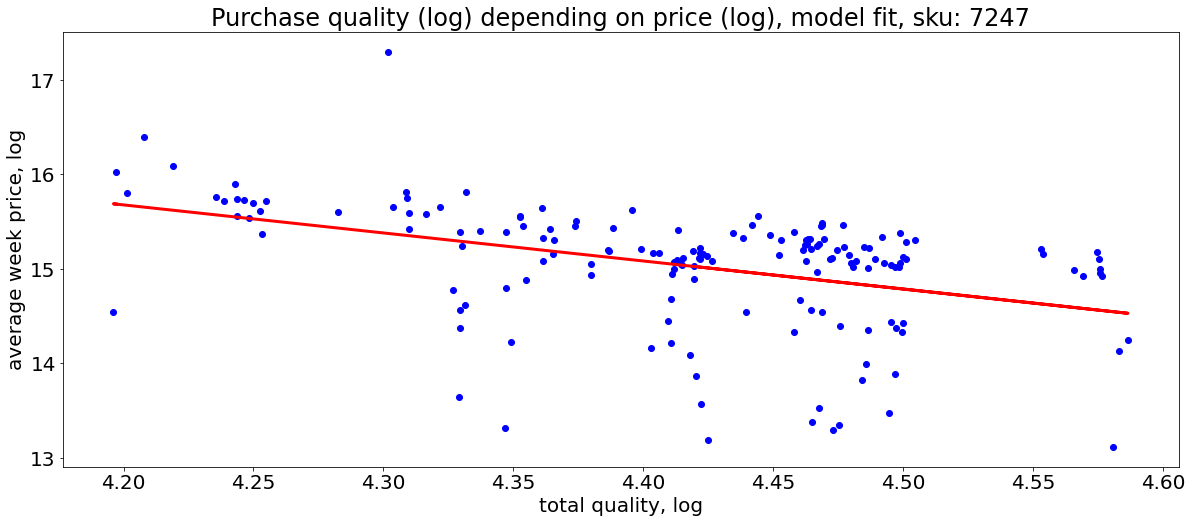

In [167]:
plt.figure(figsize=(20,8))

ids = df_agg['skutertiaryid'] == 7182 

plt.scatter(
    df_agg[ids]['price_log'],
    df_agg[ids]['Q_log'],
    color='blue'
);

plt.plot(
    df_agg[ids]['price_log'],
    k*df_agg[ids]['price_log'] + b,
    linewidth=3,
    color='red'
)

#plt.ylim(0, 200_000);
plt.title(f'Purchase quality (log) depending on price (log), model fit, sku: {sku}');
plt.xlabel('total quality, log');
plt.ylabel('average week price, log');
plt.rcParams.update({'font.size': 20});
plt.savefig('plots/Purch_quality_depending_on_price_model')

----

---

$$ 
 \sum_{sku=1}^{10} Q_{sku}(P_{sku}) \to max \\
 Q_{sku}(P_{sku}) * P_{sku} *(P_{sku} - P_{sku}^{orig}) = X/10, \quad sku=1,..10 \\
 P_{sku} <= P_{sku}^{orig} \\
$$

$$ Q_{sku} - товарооборот, шт.$$
$$ P_{sku}^{oirg} - оригинальная\quadцена\quad sku, руб. $$
$$ X - бюджет\quadна\quad sku, руб.$$

---

$$ Q_{t}(P_{t}, Q_{t-1}, .., Q_{t-n}, P_{t-1}, .., P_{t-n}) $$

In [220]:
x = np.arange(10, 100, 5)
y = np.sqrt(100**2 - x**2)

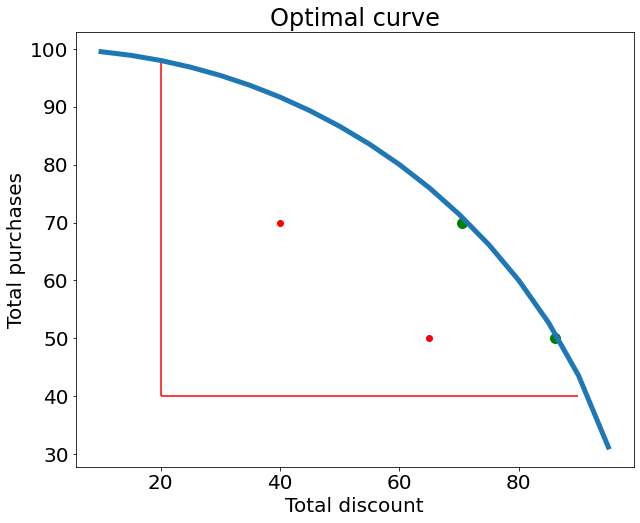

In [219]:
plt.figure(figsize=(10, 8))

plt.scatter(
    [70.5, 86], 
    [70, 50], 
    color='green', 
    linewidth=5
)

plt.plot(
    x, y, 
    linewidth=5
);

plt.scatter(
    [40, 65], 
    [70, 50], 
    color='red'
)

plt.vlines(20, 40, 98, color='red')
plt.hlines(40, 20, 90, color='red')


plt.xlabel('Total discount');
plt.ylabel('Total purchases');
plt.title('Optimal curve');
plt.savefig('plots/optimal_curve')